# **1. Introduction** <a class="anchor" id="1"></a>

## **1.2. Import packages**

In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import math
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_profiling import ProfileReport
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
# Feature selection
from sklearn.feature_selection import VarianceThreshold

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

from sklearn import random_projection

from scipy.cluster.hierarchy import dendrogram


## **1.3. Import data**

In [2]:
data = pd.read_csv('data/donors.csv',index_col='CONTROLN', low_memory=False)
print("The data set has total %d records and %d features" %data.shape)

The data set has total 95412 records and 475 features


## 1.4. Functions for the analysis

In [3]:
def unique_check_categorical(df, threshold):
    table = df.describe(include=['O'])
    highly_unique = []
    for col in table.columns:
        f = table.loc['freq',col]/table.loc['count',col]
        if f > threshold:
            highly_unique.append(col)
            print(col, ', percentage of top unique value = %.2f %%' %(100*f))
    if len(highly_unique) == 0:
        print('There is no column has too high percentage of a value')


def unique_check_numerical(df, threshold):
    variables_detected = []
    for i in df:
        if (df[i].value_counts()[0] / len(df)) > threshold:
            variables_detected.append(i)
    return variables_detected


#find features with correlations greater than 0.9 in order to remove them
def correlation_check(df, limit = 0.90, drop = False):
    corr = df.corr()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    corr_no_diag = corr.where(mask)
    coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]
    if drop is True:        
        df.drop(coll,axis = 1,inplace=True)
        print('Dropped:', coll)
        return df
    else:
        print('Columns having high correlation:', coll)  


# checking the value counts
def check_value_counts(df):
    for i in df:
        print(i)
        print(df[i].value_counts())
        print('-------------------')

In [4]:
def boxplot_func(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))
  
    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(data=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    
    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    sns.despine(bottom=True)
    plt.show()
    
def histplot_func(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(24,2*rows))
       
    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.histplot(data=df.loc[:,i[1]], bins=20,ax=i[0])
        i[0].set_xlabel(i[1])
        i[0].set_ylabel("")
      
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Histograms", fontsize=15)
    sns.despine(bottom=True)
    plt.show()
    
def corrheatmap(dataframe):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":10}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()

# **2. Pre-processing data:** <a class="anchor" id="1"></a>

After conducting **Exploratory Data Analysis (Appendix 1)** for 475 features of the original data set, we have listed out the most significant features that we consider to be important for the clustering task.  
Thus, from now, we will continue with these selected features:

In [5]:
# Import the database we create for selecting the features:
features_list = pd.read_csv('Selected_Features.csv',index_col=0)
features_list.head()

FeaturesName                                    Description  \
Index                                                               
1          ODATEDW        Origin Date. Date of donor's first gift   
2          OSOURCE                                  Origin Source   
3            TCODE                               Donor title code   
4            STATE  State abbreviation (a nominal/symbolic field)   
5              ZIP             Zipcode (a nominal/symbolic field)   

              Category SubCategory Selected  
Index                                        
1      Characteristics         NaN        x  
2      Characteristics         NaN        x  
3      Characteristics         NaN        x  
4      Characteristics         NaN        x  
5      Characteristics         NaN        x

In [6]:
# Get the selected features
selected_feats = features_list[features_list['Selected'] == 'x']['FeaturesName']
df = data[selected_feats].copy()
df.dtypes

# function to update slected features dataframe everytime we adjust the data
def update_selected_feats_list(df, features_list):
    selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
    return selected_feats

# **Feature engineering:** <a class="anchor" id="1"></a>


### **2.1. Getting the Age of every donor:** <a class="anchor" id="1"></a>

We notice that there is one feature called DOB - Day of Birth of the donors, so we thought it would we useful to generate the age of the donors as one feature. The donor's age will be measured at the time the donor received the most recent promotion which is recorded in 'MAXADATE' feature.

In [7]:
df['DOB'].head()

CONTROLN
95515     1957-12-01
148535    1972-02-01
15078            NaN
172556    1948-01-01
7112      1940-01-01
Name: DOB, dtype: object

In [8]:
#converting the DOB column to datetime type
parsed_dates = pd.to_datetime(df.DOB, format='%Y-%m-%d' , errors='coerce') #errors='coerce' meant to return NaN in case of exception
df['DOB'] = parsed_dates
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'], format='%Y-%m-%d' , errors='coerce')
# Getting the age of every donor today
df['AGE'] = ((df['MAXADATE'] - df['DOB']).dt.days/365).floordiv(other=1).astype('int',errors='ignore')

# Append new features to the feature list
feats = pd.DataFrame([['AGE', "Age of the donor","Characteristics","","x" ]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now, drop de DOB column as it is no longer useful
df.drop('DOB',inplace=True,axis = 1)

### **2.2. Converting binary features of mailing activity:** <a class="anchor" id="1"></a>

There are features containing binary information but they are not in the right data type for processing, so we convert them to binary type

In [9]:
df.loc[:, 'COLLECT1':'PLATES'].head()

COLLECT1 VETERANS BIBLE CATLG HOMEE PETS CDPLAY STEREO PCOWNERS  \
CONTROLN                                                                   
95515                                                                      
148535                                                                     
15078                                                                      
172556                                                                     
7112                           Y     Y                        Y            

         PHOTO CRAFTS FISHER GARDENIN BOATS WALKER KIDSTUFF CARDS PLATES  
CONTROLN                                                                  
95515                                                                     
148535                                                                    
15078                                                                     
172556                                                                    
7112                Y               Y            Y              Y

In [10]:
#Replace the values for booleans
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace(' ',0)
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace('Y',1)
df.loc[:, 'COLLECT1':'PLATES'].head()

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  \
CONTROLN                                                                  
95515            0         0      0      0      0     0       0       0   
148535           0         0      0      0      0     0       0       0   
15078            0         0      0      0      0     0       0       0   
172556           0         0      0      0      0     0       0       0   
7112             0         0      1      1      0     0       0       1   

          PCOWNERS  PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  \
CONTROLN                                                                       
95515            0      0       0       0         0      0       0         0   
148535           0      0       0       0         0      0       0         0   
15078            0      0       0       0         0      0       0         0   
172556           0      0       0       0         0      0       0         0   
7112             0      0       1       0         1      0       1         0   

          CARDS  PLATES  
CONTROLN                 
95515         0       0  
148535        0       0  
15078         0       0  
172556        0       0  
7112          1       0

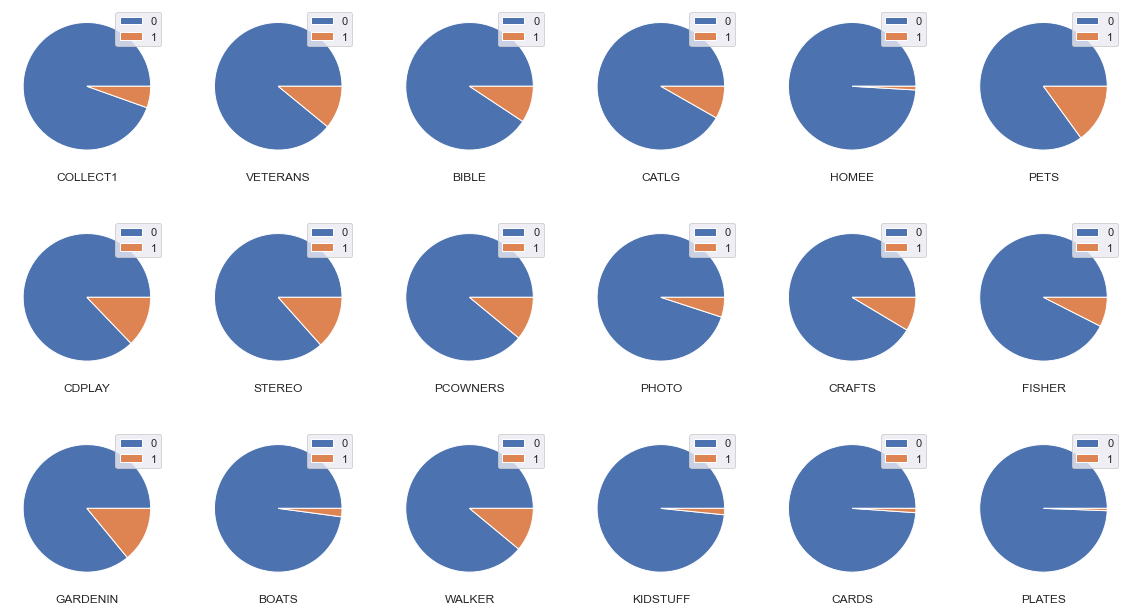

In [11]:
# Plot the result
plotdf = df.loc[:, 'COLLECT1':'PLATES'].apply(pd.value_counts)
#plot pie charts for all the interests
sns.set()
fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
    ax.pie(plotdf[feat])
    ax.set_title(feat, y=-0.13)
    ax.legend(plotdf.index)
plt.show() 

### **2.3. Generate RFA status of the each donor before they are considered to be Lapsed Donor:** <a class="anchor" id="1"></a>

Because all the donors which is investigated in this dataset is all Lapsed Donors as the date of the lasted promotion, so we will not able to undestand the 'Recency' charateristics if we only consider the most recent code of the donor (all 'Lapsed').  

Therefore, we thought it would be interesting if we get the most recent type of code of each donor before they are considered to become Lapsed Donors

We will consider the data in features **Donor's RFA status as of XXXX promotion date (XXXX is from 'RFA_3'to 'RFA_24')**

In [12]:
# Replace the blank values with NaN value
df.loc[:,'RFA_3':'RFA_24'] = df.loc[:,'RFA_3':'RFA_24'].replace({' ' : np.NaN})
# Find the second most recent type of a donor by the left-most available values from RFA_3 to RFA_24
df['RFA_USEDTO'] = df.loc[:,'RFA_3':'RFA_24'].fillna(method = 'bfill',axis = 1)['RFA_3']
# Renerate R, F, A features
df['RFA_USEDTO_R'] = df['RFA_USEDTO'].apply(lambda x: str(x)[0])
df['RFA_USEDTO_F'] = df['RFA_USEDTO'].apply(lambda x: str(x)[1])
df['RFA_USEDTO_A'] = df['RFA_USEDTO'].apply(lambda x: str(x)[2])

# Add to the selected features list
feats = pd.DataFrame([['RFA_USEDTO_R', "Recency code of the previous status of the donor","Promotion and Gift","","x" ],
                    ['RFA_USEDTO_F', "Frequency code of the previous status of the donor","Promotion and Gift","","x"], 
                    ['RFA_USEDTO_A', "Amount code of the previous status of the donor","Promotion and Gift","","x"]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now drop the features that is no longer useful
df.drop(labels='RFA_USEDTO',axis=1,inplace = True, errors='ignore')
# Check for the result
df.loc[:,'RFA_USEDTO_R':'RFA_USEDTO_A'].head()

RFA_USEDTO_R RFA_USEDTO_F RFA_USEDTO_A
CONTROLN                                       
95515               S            4            E
148535              A            2            G
15078               S            4            E
172556              S            4            E
7112                A            2            F

In [13]:
# Drop the RFA status of donor as they are no longer useful
df.drop(labels=df.loc[:,'RFA_3':'RFA_24'].columns,axis=1,inplace=True,errors='ignore')
df.head()

ODATEDW OSOURCE  TCODE STATE    ZIP MAILCODE MDMAUD DOMAIN  \
CONTROLN                                                                  
95515     2009-01-01     GRI      0    IL  61081            XXXX     T2   
148535    2014-01-01     BOA      1    CA  91326            XXXX     S1   
15078     2010-01-01     AMH      1    NC  27017            XXXX     R2   
172556    2007-01-01     BRY      0    CA  95953            XXXX     R2   
7112      2006-01-01              0    FL  33176            XXXX     S2   

         HOMEOWNR CHILD03  ... RFA_2F RFA_2A MDMAUD_R  MDMAUD_F  MDMAUD_A  \
CONTROLN                   ...                                              
95515                      ...      4      E        X         X         X   
148535          H          ...      2      G        X         X         X   
15078           U          ...      4      E        X         X         X   
172556          U          ...      4      E        X         X         X   
7112            H          ...      2      F        X         X         X   

         GEOCODE2   AGE  RFA_USEDTO_R  RFA_USEDTO_F  RFA_USEDTO_A  
CONTROLN                                                           
95515           C  59.0             S             4             E  
148535          A  45.0             A             2             G  
15078           C   NaN             S             4             E  
172556          C  69.0             S             4             E  
7112            A  77.0             A             2             F  

[5 rows x 158 columns]

### Now we have 158 features

In [14]:
selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
selected_feats.head()

FeaturesName                                    Description  \
0      ODATEDW        Origin Date. Date of donor's first gift   
1      OSOURCE                                  Origin Source   
2        TCODE                               Donor title code   
3        STATE  State abbreviation (a nominal/symbolic field)   
4          ZIP             Zipcode (a nominal/symbolic field)   

          Category SubCategory Selected  
0  Characteristics         NaN        x  
1  Characteristics         NaN        x  
2  Characteristics         NaN        x  
3  Characteristics         NaN        x  
4  Characteristics         NaN        x

In [15]:
# Summary by category
pd.DataFrame(selected_feats.groupby('Category')['FeaturesName'].count())

FeaturesName
Category                        
Characteristics               23
Interests                     19
Mail response                 14
Neighborhood                  75
Promotion and Gift            27

# **3. Data cleaning:** <a class="anchor" id="1"></a>

In [16]:
df

ODATEDW OSOURCE  TCODE STATE    ZIP MAILCODE MDMAUD DOMAIN  \
CONTROLN                                                                  
95515     2009-01-01     GRI      0    IL  61081            XXXX     T2   
148535    2014-01-01     BOA      1    CA  91326            XXXX     S1   
15078     2010-01-01     AMH      1    NC  27017            XXXX     R2   
172556    2007-01-01     BRY      0    CA  95953            XXXX     R2   
7112      2006-01-01              0    FL  33176            XXXX     S2   
...              ...     ...    ...   ...    ...      ...    ...    ...   
184568    2016-01-01     ASE      1    AK  99504            XXXX     C2   
122706    2016-01-01     DCD      1    TX  77379            XXXX     C1   
189641    2015-01-01     MBC      1    MI  48910            XXXX     C3   
4693      2006-01-01     PRV      0    CA  91320            XXXX     C1   
185114    2008-01-01     MCC      2    NC  28409            C1CM     C1   

         HOMEOWNR CHILD03  ... RFA_2F RFA_2A MDMAUD_R  MDMAUD_F  MDMAUD_A  \
CONTROLN                   ...                                              
95515                      ...      4      E        X         X         X   
148535          H          ...      2      G        X         X         X   
15078           U          ...      4      E        X         X         X   
172556          U          ...      4      E        X         X         X   
7112            H          ...      2      F        X         X         X   
...           ...     ...  ...    ...    ...      ...       ...       ...   
184568                     ...      1      G        X         X         X   
122706          H          ...      1      F        X         X         X   
189641                     ...      3      E        X         X         X   
4693            H          ...      4      F        X         X         X   
185114          U          ...      1      G        C         1         C   

         GEOCODE2   AGE  RFA_USEDTO_R  RFA_USEDTO_F  RFA_USEDTO_A  
CONTROLN                                                           
95515           C  59.0             S             4             E  
148535          A  45.0             A             2             G  
15078           C   NaN             S             4             E  
172556          C  69.0             S             4             E  
7112            A  77.0             A             2             F  
...           ...   ...           ...           ...           ...  
184568          C   NaN             F             1             G  
122706          A  47.0             P             1             F  
189641          B  59.0             S             4             E  
4693            A  56.0             S             4             F  
185114          C  79.0             A             1             G  

[95412 rows x 158 columns]

## 3.1. Check for features interpretability:

In this section, we will access the ability to interpret the feature based on its description, number of unique values and nulls values.  
We also try to engineer some features for better interpretation

### 3.1.1. Characteristics features:

In [17]:
selected_feats[selected_feats['Category'] == 'Characteristics']

FeaturesName                                        Description  \
0        ODATEDW            Origin Date. Date of donor's first gift   
1        OSOURCE                                      Origin Source   
2          TCODE                                   Donor title code   
3          STATE      State abbreviation (a nominal/symbolic field)   
4            ZIP                 Zipcode (a nominal/symbolic field)   
5       MAILCODE                                          Mail Code   
13        MDMAUD                        The Major Donor Matrix code   
14        DOMAIN  DOMAIN/Cluster code. A nominal or symbolic field.   
15      HOMEOWNR                                    Home Owner Flag   
16       CHILD03                       Presence of Children age 0-3   
17       CHILD07                       Presence of Childern age 4-7   
18       CHILD12                      Presence of Childern age 8-12   
19       CHILD18                     Presence of Childern age 13-18   
20       NUMCHLD                                 NUMBER OF CHILDREN   
21        INCOME                                   HOUSEHOLD INCOME   
22        GENDER                                             Gender   
23       WEALTH1                                      Wealth Rating   
24           HIT               MOR Flag # HIT (Mail Order Response)   
49         MAJOR                              Major ($$) Donor Flag   
50       WEALTH2                                      Wealth Rating   
51       GEOCODE  Geo Cluster Code indicating the level geograph...   
474     GEOCODE2                                   County Size Code   
475          AGE                                   Age of the donor   

            Category SubCategory Selected  
0    Characteristics         NaN        x  
1    Characteristics         NaN        x  
2    Characteristics         NaN        x  
3    Characteristics         NaN        x  
4    Characteristics         NaN        x  
5    Characteristics         NaN        x  
13   Characteristics         NaN        x  
14   Characteristics         NaN        x  
15   Characteristics         NaN        x  
16   Characteristics         NaN        x  
17   Characteristics         NaN        x  
18   Characteristics         NaN        x  
19   Characteristics         NaN        x  
20   Characteristics         NaN        x  
21   Characteristics         NaN        x  
22   Characteristics         NaN        x  
23   Characteristics         NaN        x  
24   Characteristics         NaN        x  
49   Characteristics         NaN        x  
50   Characteristics         NaN        x  
51   Characteristics         NaN        x  
474  Characteristics         NaN        x  
475  Characteristics                    x

In [18]:
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']
df[char_feats]

ODATEDW OSOURCE  TCODE STATE    ZIP MAILCODE MDMAUD DOMAIN  \
CONTROLN                                                                  
95515     2009-01-01     GRI      0    IL  61081            XXXX     T2   
148535    2014-01-01     BOA      1    CA  91326            XXXX     S1   
15078     2010-01-01     AMH      1    NC  27017            XXXX     R2   
172556    2007-01-01     BRY      0    CA  95953            XXXX     R2   
7112      2006-01-01              0    FL  33176            XXXX     S2   
...              ...     ...    ...   ...    ...      ...    ...    ...   
184568    2016-01-01     ASE      1    AK  99504            XXXX     C2   
122706    2016-01-01     DCD      1    TX  77379            XXXX     C1   
189641    2015-01-01     MBC      1    MI  48910            XXXX     C3   
4693      2006-01-01     PRV      0    CA  91320            XXXX     C1   
185114    2008-01-01     MCC      2    NC  28409            C1CM     C1   

         HOMEOWNR CHILD03  ... NUMCHLD INCOME GENDER  WEALTH1  HIT MAJOR  \
CONTROLN                   ...                                             
95515                      ...     NaN    NaN      F      NaN    0         
148535          H          ...     1.0    6.0      M      9.0   16         
15078           U          ...     NaN    3.0      M      1.0    2         
172556          U          ...     NaN    1.0      F      4.0    2         
7112            H          ...     1.0    3.0      F      2.0   60         
...           ...     ...  ...     ...    ...    ...      ...  ...   ...   
184568                     ...     NaN    NaN      M      NaN    0         
122706          H          ...     1.0    7.0      M      9.0    1         
189641                     ...     NaN    NaN      M      NaN    0         
4693            H          ...     NaN    7.0      F      NaN    0         
185114          U          ...     NaN    5.0      F      8.0    3     X   

          WEALTH2  GEOCODE GEOCODE2   AGE  
CONTROLN                                   
95515         5.0                 C  59.0  
148535        9.0       02        A  45.0  
15078         1.0                 C   NaN  
172556        0.0                 C  69.0  
7112          NaN                 A  77.0  
...           ...      ...      ...   ...  
184568        NaN                 C   NaN  
122706        NaN                 A  47.0  
189641        NaN                 B  59.0  
4693          7.0       04        A  56.0  
185114        8.0       03        C  79.0  

[95412 rows x 23 columns]

There are some columns contain missing values but in different type of format rather than NaN format. Thus, in this section, we will replace them with numpy.NaN values for better processing:

In [19]:
df[char_feats].isin([' ']).sum(axis = 0)

ODATEDW         0
OSOURCE       928
TCODE           0
STATE           0
ZIP             0
MAILCODE    94013
MDMAUD          0
DOMAIN       2316
HOMEOWNR    22228
CHILD03     94266
CHILD07     93846
CHILD12     93601
CHILD18     92565
NUMCHLD         0
INCOME          0
GENDER       2957
WEALTH1         0
HIT             0
MAJOR       95118
WEALTH2         0
GEOCODE     80168
GEOCODE2      187
AGE             0
dtype: int64

### OSOURCE

In [22]:
#droping invalid values for column OSOURCE
df = df[df.OSOURCE != ' ']

### ZIP

In [26]:
#clean all the ZIP values with hifén
df.ZIP = df.ZIP.replace("-","", regex=True)

### MAILCODE

In [28]:
#Convert Mailcode options to binary
df.loc[:, 'MAILCODE'] = df.loc[:, 'MAILCODE'].replace(' ',1)
df.loc[:, 'MAILCODE'] = df.loc[:, 'MAILCODE'].replace('B',0)

In [21]:
# Except for MAILCODE where ' ' is actually a value, we will replace all other ' ' values as NaN
for col in df[char_feats].isin([' ']).sum(axis = 0).index:
    if col == 'MAILCODE':
        next
    else:
        df[col] = df[col].replace(' ', np.NaN)

### DOMAIN

In [30]:
#droping invalid values for column DOMAIN
df = df[df.DOMAIN != ' ']

### HOMEOWNR

In [104]:
#replace NaN values for Unknown 
df.HOMEOWNR.replace(' ','U',inplace=True)

### GENDER

In [33]:
#checking all the values for the Gender
#M = Male
#F = Female
#U = Unknown
#J = Joint Account
print(df['GENDER'].unique())

#replacing unknown values to 'U'
df['GENDER'].replace(' ','U',inplace=True)
df['GENDER'].replace('A','U',inplace=True)
df['GENDER'].replace('C','U',inplace=True)

#checking the difference
print(df['GENDER'].unique())

['F' 'M' ' ' 'C' 'U' 'J' 'A']
['F' 'M' 'U' 'J']


In [36]:
unique_check_categorical(df[char_feats], 0.9)

There is no column has too high percentage of a value


In [35]:
#columns are not interesting and have lots of null values
df.drop(['MAILCODE','MDMAUD','CHILD03','CHILD07','CHILD12','CHILD18','MAJOR'],inplace=True,axis = 1)
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']

**c) Check for correlation**

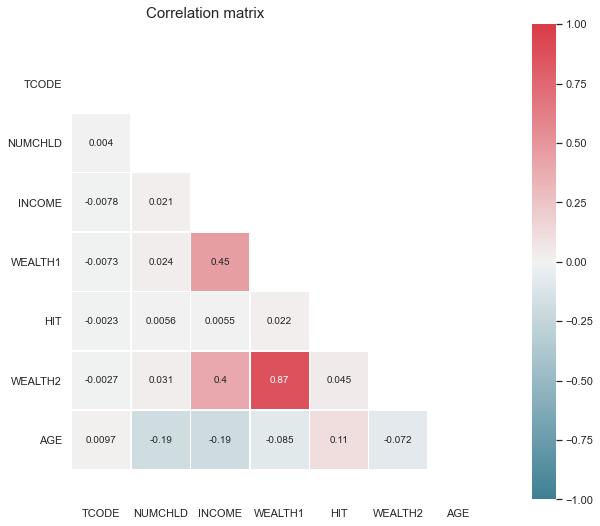

In [37]:
corrheatmap(df[char_feats])

In [27]:
correlation_check(df[char_feats])

Columns having high correlation: []


**d) Check for Nulls values:**

In [28]:
df[char_feats].isna().sum()

ODATEDW         0
OSOURCE       928
TCODE           0
STATE           0
ZIP             0
DOMAIN       2316
HOMEOWNR    22228
NUMCHLD     83026
INCOME      21286
GENDER       2957
WEALTH1     44732
HIT             0
WEALTH2     43823
GEOCODE     80168
GEOCODE2      319
AGE         23883
dtype: int64

Too many null values for NUMCHLD and GEOCODE so we will drop these columns

In [38]:
#too many null values for NUMCHLD and GEOCODE so we will drop these columns
df.drop(['NUMCHLD','GEOCODE'],inplace=True,axis = 1,errors='ignore')
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']

In [39]:
# Summary by category
pd.DataFrame(selected_feats.groupby('Category')['FeaturesName'].count())

FeaturesName
Category                        
Characteristics               14
Interests                     19
Mail response                 14
Neighborhood                  75
Promotion and Gift            27

### 3.1.2 Interests features

In [40]:
# selected features
selected_feats[selected_feats['Category'] == 'Interests']

FeaturesName                     Description   Category SubCategory  \
52     COLLECT1               COLLECTABLE (Y/N)  Interests         NaN   
53     VETERANS                  VETERANS (Y/N)  Interests         NaN   
54        BIBLE             BIBLE READING (Y/N)  Interests         NaN   
55        CATLG           SHOP BY CATALOG (Y/N)  Interests         NaN   
56        HOMEE            WORK FROM HOME (Y/N)  Interests         NaN   
57         PETS            HOUSEHOLD PETS (Y/N)  Interests         NaN   
58       CDPLAY          CD PLAYER OWNERS (Y/N)  Interests         NaN   
59       STEREO   STEREO/RECORDS/TAPES/CD (Y/N)  Interests         NaN   
60     PCOWNERS            HOME PC OWNERS/USERS  Interests         NaN   
61        PHOTO               PHOTOGRAPHY (Y/N)  Interests         NaN   
62       CRAFTS                    CRAFTS (Y/N)  Interests         NaN   
63       FISHER                   FISHING (Y/N)  Interests         NaN   
64     GARDENIN                 GARDENING (Y/N)  Interests         NaN   
65        BOATS             POWER BOATING (Y/N)  Interests         NaN   
66       WALKER           WALK FOR HEALTH (Y/N)  Interests         NaN   
67     KIDSTUFF  BUYS CHILDREN'S PRODUCTS (Y/N)  Interests         NaN   
68        CARDS    STATIONARY/CARDS BUYER (Y/N)  Interests         NaN   
69       PLATES           PLATE COLLECTOR (Y/N)  Interests         NaN   
70      LIFESRC          LIFE STYLE DATA SOURCE  Interests         NaN   

   Selected  
52        x  
53        x  
54        x  
55        x  
56        x  
57        x  
58        x  
59        x  
60        x  
61        x  
62        x  
63        x  
64        x  
65        x  
66        x  
67        x  
68        x  
69        x  
70        x

In [41]:
interests_feats = selected_feats[selected_feats['Category'] == 'Interests']['FeaturesName']

df[interests_feats]

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  \
CONTROLN                                                                  
95515            0         0      0      0      0     0       0       0   
148535           0         0      0      0      0     0       0       0   
15078            0         0      0      0      0     0       0       0   
172556           0         0      0      0      0     0       0       0   
47784            0         0      0      0      0     0       0       0   
...            ...       ...    ...    ...    ...   ...     ...     ...   
184568           0         0      0      0      0     0       0       0   
122706           0         0      0      0      0     0       0       0   
189641           0         0      0      0      0     0       0       0   
4693             0         0      0      0      0     0       0       0   
185114           0         0      0      0      0     0       0       0   

          PCOWNERS  PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  \
CONTROLN                                                                       
95515            0      0       0       0         0      0       0         0   
148535           0      0       0       0         0      0       0         0   
15078            0      0       0       0         0      0       0         0   
172556           0      0       0       0         0      0       0         0   
47784            0      0       0       0         0      0       0         0   
...            ...    ...     ...     ...       ...    ...     ...       ...   
184568           0      0       0       0         0      0       0         0   
122706           0      0       0       0         0      0       0         0   
189641           0      0       0       0         0      0       0         0   
4693             0      0       0       0         0      0       0         0   
185114           0      0       0       0         0      0       0         0   

          CARDS  PLATES LIFESRC  
CONTROLN                         
95515         0       0          
148535        0       0          
15078         0       0          
172556        0       0          
47784         0       0          
...         ...     ...     ...  
184568        0       0          
122706        0       0          
189641        0       0          
4693          0       0       1  
185114        0       0          

[92274 rows x 19 columns]

**a) Feature engineering:**

In [42]:
df[interests_feats].isin([' ']).sum(axis = 0)

COLLECT1        0
VETERANS        0
BIBLE           0
CATLG           0
HOMEE           0
PETS            0
CDPLAY          0
STEREO          0
PCOWNERS        0
PHOTO           0
CRAFTS          0
FISHER          0
GARDENIN        0
BOATS           0
WALKER          0
KIDSTUFF        0
CARDS           0
PLATES          0
LIFESRC     52140
dtype: int64

In [43]:
# We have blank space only in the variable LIFESRC (LIFE STYLE DATA SOURCE)
df['LIFESRC'] = df['LIFESRC'].replace(' ', np.NaN)

**b) Check for unique values:**

In [44]:
df[interests_feats].describe()

COLLECT1      VETERANS         BIBLE         CATLG         HOMEE  \
count  92274.000000  92274.000000  92274.000000  92274.000000  92274.000000   
mean       0.054804      0.109153      0.093320      0.082602      0.009353   
std        0.227599      0.311833      0.290882      0.275281      0.096256   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               PETS        CDPLAY        STEREO      PCOWNERS         PHOTO  \
count  92274.000000  92274.000000  92274.000000  92274.000000  92274.000000   
mean       0.150779      0.128953      0.134415      0.110573      0.050198   
std        0.357835      0.335150      0.341099      0.313604      0.218355   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             CRAFTS        FISHER      GARDENIN         BOATS        WALKER  \
count  92274.000000  92274.000000  92274.000000  92274.000000  92274.000000   
mean       0.086070      0.075417      0.141047      0.021328      0.110508   
std        0.280469      0.264064      0.348072      0.144475      0.313523   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           KIDSTUFF         CARDS        PLATES  
count  92274.000000  92274.000000  92274.000000  
mean       0.016115      0.010902      0.005961  
std        0.125919      0.103844      0.076974  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000

In [45]:
unique_check_categorical(df[interests_feats], 0.6)

There is no column has too high percentage of a value


In [46]:
unique_check_numerical(df[interests_feats], 0.9)

['COLLECT1',
 'BIBLE',
 'CATLG',
 'HOMEE',
 'PHOTO',
 'CRAFTS',
 'FISHER',
 'BOATS',
 'KIDSTUFF',
 'CARDS',
 'PLATES']

In [47]:
check_value_counts(df[interests_feats])

COLLECT1
0    87217
1     5057
Name: COLLECT1, dtype: int64
-------------------
VETERANS
0    82202
1    10072
Name: VETERANS, dtype: int64
-------------------
BIBLE
0    83663
1     8611
Name: BIBLE, dtype: int64
-------------------
CATLG
0    84652
1     7622
Name: CATLG, dtype: int64
-------------------
HOMEE
0    91411
1      863
Name: HOMEE, dtype: int64
-------------------
PETS
0    78361
1    13913
Name: PETS, dtype: int64
-------------------
CDPLAY
0    80375
1    11899
Name: CDPLAY, dtype: int64
-------------------
STEREO
0    79871
1    12403
Name: STEREO, dtype: int64
-------------------
PCOWNERS
0    82071
1    10203
Name: PCOWNERS, dtype: int64
-------------------
PHOTO
0    87642
1     4632
Name: PHOTO, dtype: int64
-------------------
CRAFTS
0    84332
1     7942
Name: CRAFTS, dtype: int64
-------------------
FISHER
0    85315
1     6959
Name: FISHER, dtype: int64
-------------------
GARDENIN
0    79259
1    13015
Name: GARDENIN, dtype: int64
-------------------
BOATS
0 

In [48]:
# dropping the variables with too many unique values = 0. It means that the interest is not that common, so probably no useful to detect clusters
df = df.drop(columns=['COLLECT1','BIBLE','CATLG','HOMEE','PHOTO','CRAFTS', 'FISHER','BOATS','KIDSTUFF','CARDS','PLATES'])

**c) Check for correlation:**

In [49]:
# updating the interest's list
interests_feats = ['VETERANS', 'PETS','CDPLAY', 'STEREO', 'PCOWNERS','GARDENIN', 'WALKER', 'LIFESRC']

In [50]:
correlation_check(df[interests_feats])

Columns having high correlation: []


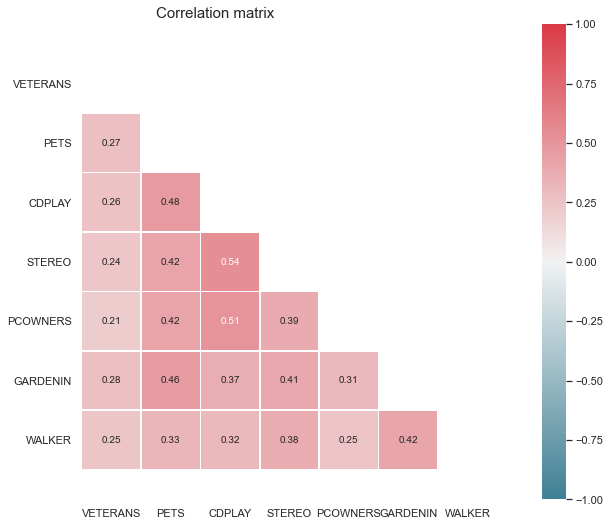

In [51]:
corrheatmap(df[interests_feats])

We have low correlations between these variables, that's goood

**d) Check for null values:**

In [52]:
df[interests_feats].isna().sum()

VETERANS        0
PETS            0
CDPLAY          0
STEREO          0
PCOWNERS        0
GARDENIN        0
WALKER          0
LIFESRC     52140
dtype: int64

In [53]:
# We have many Nan values for the variable LIFESRC, so we decide to drop also this variable
df = df.drop(columns='LIFESRC')

### 3.1.3 Mail response features

In [54]:
# selected features
selected_feats[selected_feats['Category'] == 'Mail response']

FeaturesName               Description       Category SubCategory Selected
25      MBCRAFT           Buy Craft Hobby  Mail response         NaN        x
26     MBGARDEN             Buy Gardening  Mail response         NaN        x
27      MBBOOKS                 Buy Books  Mail response         NaN        x
28     MBCOLECT          Buy Collectables  Mail response         NaN        x
29      MAGFAML   Buy General Family Mags  Mail response         NaN        x
30       MAGFEM           Buy Female Mags  Mail response         NaN        x
31      MAGMALE           Buy Sports Mags  Mail response         NaN        x
32     PUBGARDN            Gardening Pubs  Mail response         NaN        x
33     PUBCULIN             Culinary Pubs  Mail response         NaN        x
34      PUBHLTH               Health Pubs  Mail response         NaN        x
35     PUBDOITY       Do It Yourself Pubs  Mail response         NaN        x
36     PUBNEWFN       News / Finance Pubs  Mail response         NaN        x
37     PUBPHOTO          Photography Pubs  Mail response         NaN        x
38       PUBOPP  Opportunity Seekers Pubs  Mail response         NaN        x

In [55]:
mail_feats = selected_feats[selected_feats['Category'] == 'Mail response']['FeaturesName']

df[mail_feats]

MBCRAFT  MBGARDEN  MBBOOKS  MBCOLECT  MAGFAML  MAGFEM  MAGMALE  \
CONTROLN                                                                   
95515         NaN       NaN      NaN       NaN      NaN     NaN      NaN   
148535        0.0       0.0      3.0       1.0      1.0     1.0      0.0   
15078         0.0       0.0      1.0       0.0      0.0     0.0      0.0   
172556        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
47784         NaN       NaN      NaN       NaN      NaN     NaN      NaN   
...           ...       ...      ...       ...      ...     ...      ...   
184568        NaN       NaN      NaN       NaN      NaN     NaN      NaN   
122706        0.0       0.0      1.0       0.0      0.0     0.0      0.0   
189641        NaN       NaN      NaN       NaN      NaN     NaN      NaN   
4693          NaN       NaN      NaN       NaN      NaN     NaN      NaN   
185114        0.0       0.0      0.0       0.0      1.0     0.0      0.0   

          PUBGARDN  PUBCULIN  PUBHLTH  PUBDOITY  PUBNEWFN  PUBPHOTO  PUBOPP  
CONTROLN                                                                     
95515          NaN       NaN      NaN       NaN       NaN       NaN     NaN  
148535         0.0       0.0      2.0       0.0       3.0       0.0     0.0  
15078          0.0       0.0      1.0       0.0       0.0       0.0     0.0  
172556         0.0       0.0      0.0       0.0       0.0       0.0     1.0  
47784          NaN       NaN      NaN       NaN       NaN       NaN     NaN  
...            ...       ...      ...       ...       ...       ...     ...  
184568         NaN       NaN      NaN       NaN       NaN       NaN     NaN  
122706         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
189641         NaN       NaN      NaN       NaN       NaN       NaN     NaN  
4693           NaN       NaN      NaN       NaN       NaN       NaN     NaN  
185114         0.0       0.0      0.0       0.0       0.0       0.0     1.0  

[92274 rows x 14 columns]

In [56]:
df[mail_feats].describe()

MBCRAFT      MBGARDEN       MBBOOKS      MBCOLECT       MAGFAML  \
count  41242.000000  41242.000000  41242.000000  41184.000000  41242.000000   
mean       0.153072      0.059236      1.114252      0.063034      0.449275   
std        0.471301      0.262247      1.668392      0.295264      0.821122   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      2.000000      0.000000      1.000000   
max        6.000000      4.000000      9.000000      6.000000      9.000000   

             MAGFEM       MAGMALE      PUBGARDN      PUBCULIN       PUBHLTH  \
count  41242.000000  41242.000000  41242.000000  41242.000000  41242.000000   
mean       0.126425      0.066098      0.141676      0.144658      0.711944   
std        0.380817      0.277063      0.491266      0.426930      1.247056   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      1.000000   
max        5.000000      4.000000      5.000000      6.000000      9.000000   

           PUBDOITY      PUBNEWFN      PUBPHOTO        PUBOPP  
count  41242.000000  41242.000000  41242.000000  41242.000000  
mean       0.238640      0.373939      0.005868      0.237016  
std        0.731526      0.955004      0.077949      0.873933  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000  
max        8.000000      9.000000      2.000000      9.000000

In [57]:
unique_check_numerical(df[mail_feats], 0.5)

[]

In [58]:
check_value_counts(df[mail_feats])

MBCRAFT
0.0    36508
1.0     3439
2.0     1050
3.0      210
4.0       32
5.0        2
6.0        1
Name: MBCRAFT, dtype: int64
-------------------
MBGARDEN
0.0    39037
1.0     1995
2.0      185
3.0       22
4.0        3
Name: MBGARDEN, dtype: int64
-------------------
MBBOOKS
0.0    20677
1.0    10020
2.0     4524
3.0     2394
4.0     1420
5.0      864
6.0      519
7.0      316
9.0      314
8.0      194
Name: MBBOOKS, dtype: int64
-------------------
MBCOLECT
0.0    39050
1.0     1760
2.0      308
3.0       50
4.0       11
5.0        4
6.0        1
Name: MBCOLECT, dtype: int64
-------------------
MAGFAML
0.0    28832
1.0     8239
2.0     2775
3.0      978
4.0      319
5.0       74
6.0       17
7.0        7
9.0        1
Name: MAGFAML, dtype: int64
-------------------
MAGFEM
0.0    36666
1.0     4004
2.0      514
3.0       51
4.0        6
5.0        1
Name: MAGFEM, dtype: int64
-------------------
MAGMALE
0.0    38783
1.0     2231
2.0      193
3.0       31
4.0        4
Name: MAGMALE, dt

**c) Check for correlation:**

In [59]:
correlation_check(df[mail_feats])

Columns having high correlation: []


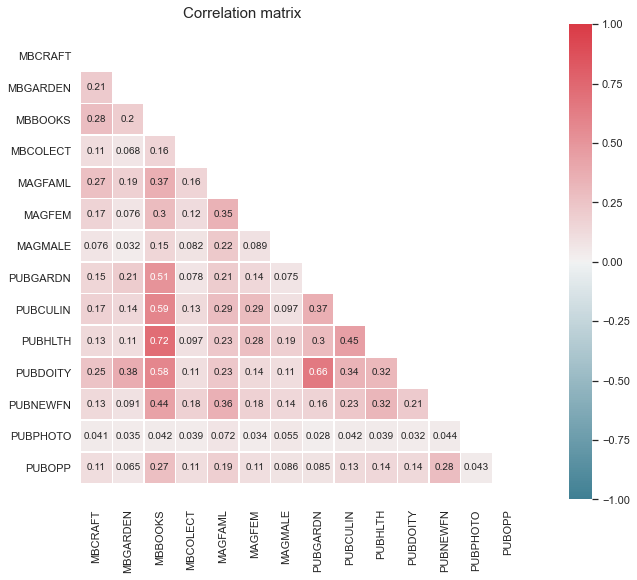

In [60]:
corrheatmap(df[mail_feats])

The highest correlation that we can notice in this heatmap is the one between the mail response for books and for public health. By the way, 0.72 is not too high. So we decide the keep both of them.

**d) Check for null values:**

In [61]:
df[mail_feats].isna().sum()

MBCRAFT     51032
MBGARDEN    51032
MBBOOKS     51032
MBCOLECT    51090
MAGFAML     51032
MAGFEM      51032
MAGMALE     51032
PUBGARDN    51032
PUBCULIN    51032
PUBHLTH     51032
PUBDOITY    51032
PUBNEWFN    51032
PUBPHOTO    51032
PUBOPP      51032
dtype: int64

In [62]:
# The percentages of the Nan are the same for all the variables, it means that we have the information of the mail reply only for a subset of our dataset
print(round(df[mail_feats].isna().sum()[0] / len(df), 3), '% of data dont have the information for all those variables')

0.553 % of data dont have the information for all those variables


By the way, for now we decide to keep these variables.

### 3.1.4. Promotion and Gift features:

In [63]:
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']
# selected features
selected_feats[selected_feats['Category'] == 'Promotion and Gift']

FeaturesName                                        Description  \
404      CARDPROM     Lifetime number of card promotions received to   
405      MAXADATE     Date of the most recent promotion received (in   
406       NUMPROM     Lifetime number of promotions received to date   
407      CARDPM12     Number of card promotions received in the last   
408      NUMPRM12       Number of promotions received in the last 12   
453      RAMNTALL            Dollar amount of lifetime gifts to date   
454      NGIFTALL                   Number of lifetime gifts to date   
455      CARDGIFT  Number of lifetime gifts to card promotions to...   
456      MINRAMNT             Dollar amount of smallest gift to date   
457      MINRDATE     Date associated with the smallest gift to date   
458      MAXRAMNT              Dollar amount of largest gift to date   
459      MAXRDATE      Date associated with the largest gift to date   
460      LASTGIFT                  Dollar amount of most recent gift   
461      LASTDATE          Date associated with the most recent gift   
462      FISTDATE                                 Date of first gift   
463      NEXTDATE                                Date of second gift   
464       TIMELAG     Number of months between first and second gift   
465       AVGGIFT             Average dollar amount of gifts to date   
468        RFA_2R                             Recency code for RFA_2   
469        RFA_2F                           Frequency code for RFA_2   
470        RFA_2A                     Donation Amount code for RFA_2   
471      MDMAUD_R                            Recency code for MDMAUD   
472      MDMAUD_F                           Frequecy code for MDMAUD   
473      MDMAUD_A                    Donation Amount code for MDMAUD   
476  RFA_USEDTO_R   Recency code of the previous status of the donor   
477  RFA_USEDTO_F  Frequency code of the previous status of the d...   
478  RFA_USEDTO_A    Amount code of the previous status of the donor   

               Category SubCategory Selected  
404  Promotion and Gift     Summary        x  
405  Promotion and Gift     Summary        x  
406  Promotion and Gift     Summary        x  
407  Promotion and Gift     Summary        x  
408  Promotion and Gift     Summary        x  
453  Promotion and Gift     Summary        x  
454  Promotion and Gift     Summary        x  
455  Promotion and Gift     Summary        x  
456  Promotion and Gift     Summary        x  
457  Promotion and Gift     Summary        x  
458  Promotion and Gift     Summary        x  
459  Promotion and Gift     Summary        x  
460  Promotion and Gift     Summary        x  
461  Promotion and Gift     Summary        x  
462  Promotion and Gift     Summary        x  
463  Promotion and Gift     Summary        x  
464  Promotion and Gift     Summary        x  
465  Promotion and Gift     Summary        x  
468  Promotion and Gift     Summary        x  
469  Promotion and Gift     Summary        x  
470  Promotion and Gift     Summary        x  
471  Promotion and Gift     Summary        x  
472  Promotion and Gift     Summary        x  
473  Promotion and Gift     Summary        x  
476  Promotion and Gift                    x  
477  Promotion and Gift                    x  
478  Promotion and Gift                    x

**a) Feature engineering:**

There are 4 date-time features that we can assume that they will not have much interpretation power for clustering.  
Those features are: **'MINRDATE', 'MAXRDATE', 'NEXTDATE' and 'TIMELAG'**.  

Thus, we decided to drop them:

In [64]:
# Remove un-relevant features
df = df.drop(columns=['MINRDATE','MAXRDATE','NEXTDATE','TIMELAG'],errors='ignore')

The remaining date-time features are 'MAXADATE', 'LASTDATE' and 'FISTDATE'. These features are useful to generate two important features in RFM (Recency, Frequency and Monetary) analysis which are Recency and Frequency.  

The 2 new features to generate are:
- Time in days since the last promotion and the last gift from the donor: 'RECENCY' = 'MAXADATE' - 'LASTDATE'  
- Time in days since the last promotion and the first gift from the donor: 'LIFETIME' = 'MAXADATE' - 'FISTDATE' 

In [65]:
# convert data to datetime 
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'])
df['LASTDATE'] = pd.to_datetime(df['LASTDATE'])
df['FISTDATE'] = pd.to_datetime(df['FISTDATE'])
# measure the recency and lifetime of donors
df['RECENCY'] = (df['MAXADATE'] - df['LASTDATE'])/pd.to_timedelta(1, unit='D')
df['LIFETIME'] = (df['MAXADATE'] - df['FISTDATE'])/pd.to_timedelta(1, unit='D')

# Add new features to the metadata
feats = pd.DataFrame([['RECENCY', "Time in days since the last promotion and the last gift from the donor","Promotion and Gift","","x" ],
                    ['LIFETIME', "Time in days since the last promotion and the first gift from the donor","Promotion and Gift","","x"]], 
                    columns=selected_feats.columns)
features_list= features_list.append(feats,ignore_index=True)
                      
# Then we drop the datetime columns:
df = df.drop(columns=['MAXADATE','FISTDATE','LASTDATE'],errors='ignore')

# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

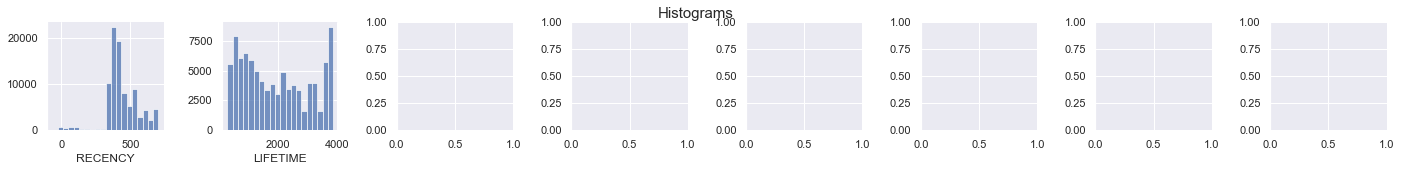

In [66]:
histplot_func(df.loc[:,['RECENCY','LIFETIME']])

**b) Check for unique values:**

In [67]:
df[PG_feats].describe(include=['O'])

RFA_2R RFA_2A MDMAUD_R MDMAUD_F MDMAUD_A RFA_USEDTO_R RFA_USEDTO_F  \
count   92274  92274    92274    92274    92274        92274        92274   
unique      1      4        5        4        5            8            4   
top         L      F        X        X        X            A            1   
freq    92274  45531    92064    92064    92064        58135        46806   

       RFA_USEDTO_A  
count         92274  
unique            7  
top               F  
freq          44756

In [68]:
unique_check_categorical(df[PG_feats], 0.9)

RFA_2R , percentage of top unique value = 100.00 %
MDMAUD_R , percentage of top unique value = 99.77 %
MDMAUD_F , percentage of top unique value = 99.77 %
MDMAUD_A , percentage of top unique value = 99.77 %


We can clearly see that features **'RFA_2R', 'MDMAUD_R', 'MDMAUD_F' and 'MDMAUD_A'** having only 1 values for mostly all of their records, thus they are considered redundant in this cluster analysis

In [69]:
# Drop these redundant columns
df = df.drop(columns=['RFA_2R', 'MDMAUD_R', 'MDMAUD_F','MDMAUD_A'],errors='ignore')
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

**c) Check for correlation**

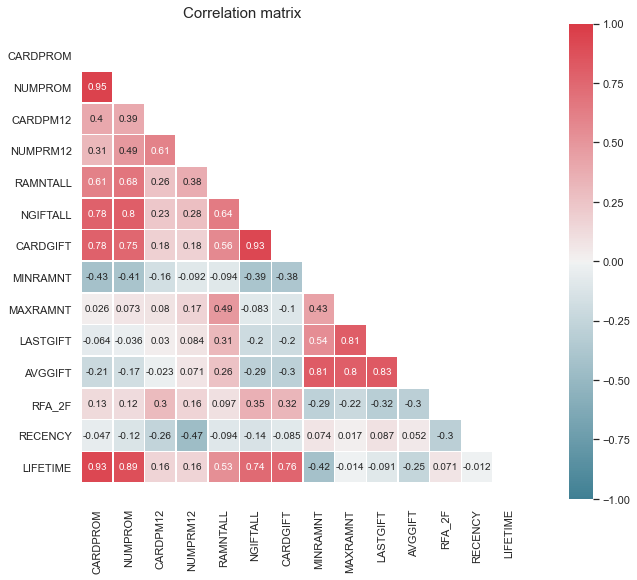

In [70]:
corrheatmap(df[PG_feats])

In [71]:
correlation_check(df[PG_feats])

Columns having high correlation: ['NUMPROM', 'CARDGIFT', 'LIFETIME']


In [72]:
# Drop these redundant columns
df = df.drop(columns=['NUMPROM', 'CARDGIFT', 'LIFETIME'])
# Update the seleted features list
selected_feats = update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

**d) Check for Nulls values:**

In [73]:
df[PG_feats].isna().sum()

CARDPROM        0
CARDPM12        0
NUMPRM12        0
RAMNTALL        0
NGIFTALL        0
MINRAMNT        0
MAXRAMNT        0
LASTGIFT        0
AVGGIFT         0
RFA_2F          0
RFA_2A          0
RFA_USEDTO_R    0
RFA_USEDTO_F    0
RFA_USEDTO_A    0
RECENCY         0
dtype: int64

## 3.2. Check for outliers:

In [74]:
def IQR_OutlierRemover(df,column,n):
    #give the function the column that you want to filter and the IQR multiplicator    
    # Compute the IQR
    q1= df[column].quantile(0.25)
    q3= df[column].quantile(0.75)
    Iqr = q3 - q1

    # Compute upper and lower limit (lower_limit = Q1 -1.5*IQR | upper_limit = Q3 + 1.5*IQR)
    lower_lim = q1 - n*Iqr
    upper_lim = q3 + n*Iqr

    initial_len = df.shape[0]

    df = df[~((df[column] < lower_lim) | (df[column] > upper_lim))]

    len_afterremov = df.shape[0]

    print('Percentage of data kept after removing outliers:', np.round(len_afterremov / initial_len, 4))

    return df

<AxesSubplot:>

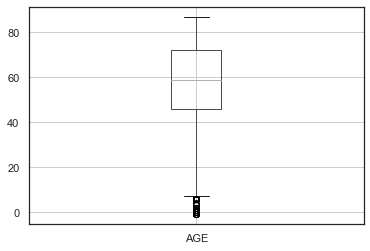

In [75]:
# Check for the box plot and distribution
df.boxplot(['AGE'])
# Here we can see that we have outliers, we will access this in the up coming session

In [76]:
df = IQR_OutlierRemover(df,'AGE',2)

Percentage of data kept after removing outliers: 1.0


<AxesSubplot:>

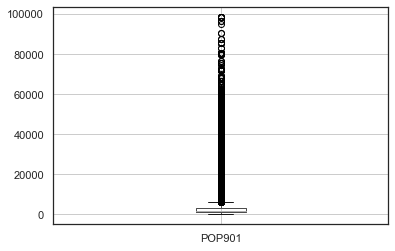

In [77]:
# Check for the box plot and distribution
df.boxplot(['POP901'])
# Here we can see that we have outliers, we will access this in the up coming session

In [78]:
df = IQR_OutlierRemover(df,'POP901',12.5)

Percentage of data kept after removing outliers: 0.9885


<AxesSubplot:>

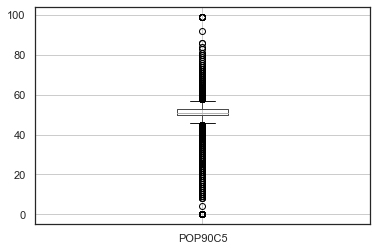

In [79]:
# Check for the box plot and distribution
df.boxplot(['POP90C5'])
# Here we can see that we have outliers, we will access this in the up coming session

In [80]:
df = IQR_OutlierRemover(df,'POP90C5',5)

Percentage of data kept after removing outliers: 0.9872


<AxesSubplot:>

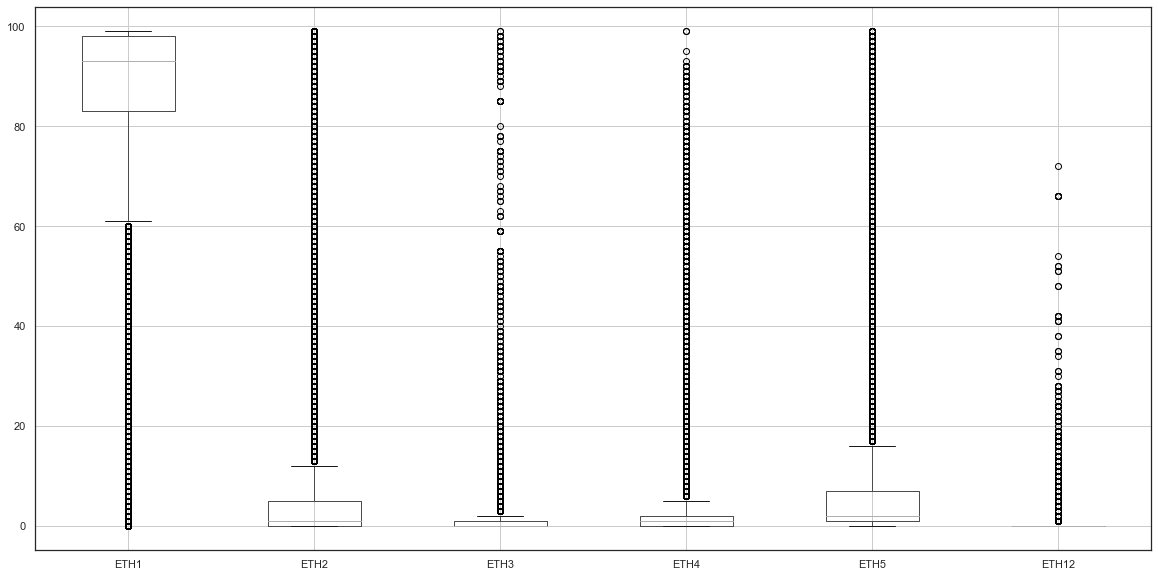

In [81]:
df.boxplot(column=['ETH1','ETH2','ETH3','ETH4','ETH5','ETH12'], figsize=(20,10))

In [82]:
df['ETH12'].describe()

count    90039.000000
mean         0.068204
std          1.179036
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         72.000000
Name: ETH12, dtype: float64

In [83]:
#i will drop this column based on its description
df.drop('ETH12', axis=1,inplace=True)

In [84]:
#Removing Outlier of some columns without getting rid of lots of data
df = IQR_OutlierRemover(df,'ETH1',5)
df = IQR_OutlierRemover(df,'ETH2',13)
df = IQR_OutlierRemover(df,'ETH3',10)
df = IQR_OutlierRemover(df,'ETH4',13)
df = IQR_OutlierRemover(df,'ETH5',12.5)

Percentage of data kept after removing outliers: 0.985
Percentage of data kept after removing outliers: 0.99
Percentage of data kept after removing outliers: 0.9907
Percentage of data kept after removing outliers: 0.9921
Percentage of data kept after removing outliers: 0.9928


In [86]:
df.isnull().sum().sort_values(ascending=False)[:20]

MBCOLECT    46748
PUBGARDN    46692
MBCRAFT     46692
PUBOPP      46692
PUBPHOTO    46692
PUBNEWFN    46692
PUBDOITY    46692
PUBHLTH     46692
PUBCULIN    46692
MAGMALE     46692
MAGFEM      46692
MAGFAML     46692
MBBOOKS     46692
MBGARDEN    46692
WEALTH1     39365
WEALTH2     38949
AGE         20816
INCOME      18532
MARR1           0
AGE901          0
dtype: int64

## 3.3. Handling with Null Values using KNN 

In [87]:
#checking if we have all-null rows
print('Initial Shape:',df.shape)
print('Shape without all-null rows',df.dropna(how='all').shape)
#we don't have so we don't remove nothing

Initial Shape: (85679, 124)
Shape without all-null rows (85679, 124)


In [88]:
df.dtypes

ODATEDW          object
OSOURCE          object
TCODE             int64
STATE            object
ZIP              object
                 ...   
AGE             float64
RFA_USEDTO_R     object
RFA_USEDTO_F     object
RFA_USEDTO_A     object
RECENCY         float64
Length: 124, dtype: object

In [110]:
df.select_dtypes(include=['object'])

OSOURCE STATE DOMAIN HOMEOWNR GENDER RFA_2A GEOCODE2 RFA_USEDTO_R  \
CONTROLN                                                                     
95515        GRI    IL     T2        U      F      E        C            S   
148535       BOA    CA     S1        H      M      G        A            A   
15078        AMH    NC     R2        U      M      E        C            S   
172556       BRY    CA     R2        U      F      E        C            S   
47784        CWR    AL     T2        U      U      F        C            A   
...          ...   ...    ...      ...    ...    ...      ...          ...   
184568       ASE    AK     C2        U      M      G        C            F   
122706       DCD    TX     C1        H      M      F        A            P   
189641       MBC    MI     C3        U      M      E        B            S   
4693         PRV    CA     C1        H      F      F        A            S   
185114       MCC    NC     C1        U      F      G        C            A   

         RFA_USEDTO_A  
CONTROLN               
95515               E  
148535              G  
15078               E  
172556              E  
47784               F  
...               ...  
184568              G  
122706              F  
189641              E  
4693                F  
185114              G  

[85679 rows x 9 columns]

In [100]:
df.RFA_USEDTO_F = df.RFA_USEDTO_F.astype('int64')
df.ZIP=df.ZIP.astype('int64')
df.ODATEDW = df.ODATEDW.astype('datetime64')

In [114]:
df_metric = df.select_dtypes(include=['float64','int64','datetime64'])
df_nonmetric = df.select_dtypes(include=['object'])

In [116]:
df_metric.isnull().sum()

ODATEDW             0
TCODE               0
ZIP                 0
INCOME          18532
WEALTH1         39365
                ...  
AVGGIFT             0
RFA_2F              0
AGE             20816
RFA_USEDTO_F        0
RECENCY             0
Length: 115, dtype: int64

In [125]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=2)
knn_imputer.fit_transform(df_metric)

KeyboardInterrupt: 

In [124]:
df_metric.drop('ODATEDW',axis=1,inplace=True)